# Code for NBA game prediction project
  
## General Introduction

This report use regular season data for each team in NBA seasons from 2004-2005 season to 2022-2023 season to predict the result of each NBA playoff tournaments (or, in other words, series) from 2004-2005 season to 2022-2023 season as well as NBA champions in these seasons.  
  
This report use CNN model and logistic regression model to achieve our goal above. We trained and tested CNN model with all numerical features except Team id, logistic regression model with further selected features and CNN model with further selected features in this report.  
  
Finally, we analyized and compared performance of our three models mentioned above. For the goal of prediction of the result of each NBA playoff tournaments, we use metrics accuracy, which is the frequency of predicted value meets the true value (more explanation in https://keras.io/api/metrics/accuracy_metrics/#accuracy-class). For the goal of prediction of NBA champions, we direcly print out the Eastern, Western and the final NBA champions predicted by our model, and check if these champions are predicted correctly.  

## Background

The National Basketball Association, or NBA, is a professional basketball league comprised of 30 teams across North America featuring the best basketball players in the world. 29 teams from the United States and 1 team from Canada are evenly split into two conferences - the Eastern Conference and the Western Conference; within the conference, teams are further divided into divisons of 5 teams, who they play the most regular season games with. One normal NBA season is comprised of the regular season and the playoff. Each team plays 82 games in the regular season, and 8 teams with the best record from each conference advance to the playoff. In the playoff, a team will play against an opponent from the same conference in a best-of-7 series, with the winner advance to the next best-of-7 series against another victorious team, and the loser gets eliminated. After 3 series, the sole remaining team from the Eastern Conference will be crowned the Eastern Conference Champions, and the last team from the Western Conference will be crowned the Western Conference Champions. These two teams will play in another best-of-7 series with the winner be crowned the NBA Champions of that season.

## Dataset notes   
### Dataset 'seasonal_data' is dataset for overall regular season performance for each NBA team since 2004-2005 season.   
### Dataset 'lis_regular_data' is dataset for each NBA team's game by game regular season data from 2004-2005 season to 2022-2023 season. 'lis_playoff_data' is dataset for each NBA team's game by game playoff data from 2004-2005 season to 2022-2023 season    
*The later 2 datasets may need some refinement since in some season there's less than 82 regular season games.  
*Modified regular season game by game data is in 'lis_regular_data_new'

## Package installation
All of our data are extracted from package nba_api

In [ ]:
pip install nba_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 5.7 MB/s eta 0:00:00


## Data Extraction
In the following code we extract our data from nba_api

In [ ]:
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
# Select the dictionary for the Celtics, which contains their team ID
celtics = [team for team in nba_teams if team['abbreviation'] == 'BOS'][0]
celtics_id = celtics['id']

from nba_api.stats.endpoints import leaguegamefinder

# Query for games where the Celtics were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=celtics_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22023,1610612738,BOS,Boston Celtics,0022300053,2023-11-28,BOS vs. CHI,W,241,124,...,0.750,11,41,52,36,6,9,16,18,27.0
1,22023,1610612738,BOS,Boston Celtics,0022300246,2023-11-26,BOS vs. ATL,W,239,113,...,0.800,18,40,58,24,9,3,12,19,10.0
2,22023,1610612738,BOS,Boston Celtics,0022300043,2023-11-24,BOS @ ORL,L,240,96,...,0.730,4,27,31,17,10,4,14,18,-17.0
3,22023,1610612738,BOS,Boston Celtics,0022300228,2023-11-22,BOS vs. MIL,W,240,119,...,0.824,4,39,43,27,3,5,15,15,3.0
4,22023,1610612738,BOS,Boston Celtics,0022300217,2023-11-20,BOS @ CHA,L,264,118,...,0.643,11,37,48,19,6,8,13,15,-3.0


In [ ]:
games['SEASON_ID'].unique()

array(['22023', '12023', '42022', '22022', '12022', '42021', '22021',
       '12021', '42020', '52020', '22020', '12020', '42019', '22019',
       '12019', '42018', '22018', '12018', '42017', '22017', '12017',
       '42016', '22016', '12016', '42015', '22015', '12015', '42014',
       '22014', '12014', '22013', '12013', '42012', '22012', '12012',
       '42011', '22011', '12011', '42010', '22010', '12010', '42009',
       '22009', '12009', '42008', '22008', '12008', '42007', '22007',
       '12007', '22006', '12006', '22005', '12005', '42004', '22004',
       '12004', '42003', '22003', '12003', '42002', '22002', '42001',
       '22001', '22000', '21999', '21998', '21997', '21996', '21995',
       '41994', '21994', '21993', '41992', '21992', '41991', '21991',
       '41990', '21990', '41989', '21989', '41988', '21988', '41987',
       '21987', '41986', '21986', '41985', '21985', '41984', '21984',
       '41983', '21983'], dtype=object)

### Code filtering NBA teams regular season data and playoff data Game by Game from 2004-2005 season to 2022-2023 season
  
*For the following datasets, only 'lis_playoff_data' is used in the preparation of training and testing data for the CNN model with all numerical features.

In [ ]:
lis_abbreviation = []
lis_regular_data = [] #regular season data
lis_playoff_data = {} #playoff data

for team in nba_teams:
    print(team['abbreviation'])
    lis_abbreviation.append(team['abbreviation'])
    id_here = team['id']
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=id_here)
    games = gamefinder.get_data_frames()[0]
    dict_regular = {}
    dict_playoff = {}

    for i in range(2004,2023):
        season_id = '2'+str(i)
        regular_data_yr = games.loc[games['SEASON_ID']==season_id].iloc[0:82,:] #filter regular season data
        numerical_features = regular_data_yr.select_dtypes(['int64', 'float64']) #drop non numerical data
        numerical_features = numerical_features.drop(columns=['TEAM_ID',"PTS",'PLUS_MINUS']) #drop variables directly
        #related to victory or failure of a game, drop useless index variable
        dict_regular['r'+str(i)]=numerical_features
        season_id2 = '4'+ str(i)

        if i==2020:
            season_id2 = '5'+ str(i)

        playoff_data_yr = games.loc[games['SEASON_ID']==season_id2] #filter playoff data
        #numerical_features = playoff_data_yr.select_dtypes(['int64', 'float64']) #drop non numerical data
        #numerical_features = numerical_features.drop(columns=['TEAM_ID',"PTS",'PLUS_MINUS']) #drop variables directly
        #related to victory or failure of a game, drop useless index variable
        dict_playoff['p'+str(i)]=playoff_data_yr

    lis_regular_data.append(dict_regular)
    lis_playoff_data[team['abbreviation']]=dict_playoff

ATL
BOS
CLE
NOP
CHI
DAL
DEN
GSW
HOU
LAC
LAL
MIA
MIL
MIN
BKN
NYK
ORL
IND
PHI
PHX
POR
SAC
SAS
OKC
TOR
UTA
MEM
WAS
DET
CHA


In [ ]:
nba_teams

[{'id': 1610612737,
  'full_name': 'Atlanta Hawks',
  'abbreviation': 'ATL',
  'nickname': 'Hawks',
  'city': 'Atlanta',
  'state': 'Georgia',
  'year_founded': 1949},
 {'id': 1610612738,
  'full_name': 'Boston Celtics',
  'abbreviation': 'BOS',
  'nickname': 'Celtics',
  'city': 'Boston',
  'state': 'Massachusetts',
  'year_founded': 1946},
 {'id': 1610612739,
  'full_name': 'Cleveland Cavaliers',
  'abbreviation': 'CLE',
  'nickname': 'Cavaliers',
  'city': 'Cleveland',
  'state': 'Ohio',
  'year_founded': 1970},
 {'id': 1610612740,
  'full_name': 'New Orleans Pelicans',
  'abbreviation': 'NOP',
  'nickname': 'Pelicans',
  'city': 'New Orleans',
  'state': 'Louisiana',
  'year_founded': 2002},
 {'id': 1610612741,
  'full_name': 'Chicago Bulls',
  'abbreviation': 'CHI',
  'nickname': 'Bulls',
  'city': 'Chicago',
  'state': 'Illinois',
  'year_founded': 1966},
 {'id': 1610612742,
  'full_name': 'Dallas Mavericks',
  'abbreviation': 'DAL',
  'nickname': 'Mavericks',
  'city': 'Dallas',

### Code collecting seasonal data for reagular seasons for each NBA team  
### Annual regular season overall data since 2004-2005 season

In [ ]:
from nba_api.stats.endpoints import teamyearbyyearstats
import pandas as pd

seasonal_data = {}
for team in nba_teams:
    print(team['abbreviation'])
    abbrev = team['abbreviation']
    id = team['id']
    obj = teamyearbyyearstats.TeamYearByYearStats(team_id = id)
    df = pd.DataFrame(data=obj.nba_response.get_data_sets()['TeamStats']['data'],\
                  columns=obj.nba_response.get_data_sets()['TeamStats']['headers'])
    df = df[df['YEAR']>='2004-05']
    seasonal_data[abbrev] = df

ATL
BOS
CLE
NOP
CHI
DAL
DEN
GSW
HOU
LAC
LAL
MIA
MIL
MIN
BKN
NYK
ORL
IND
PHI
PHX
POR
SAC
SAS
OKC
TOR
UTA
MEM
WAS
DET
CHA


### Modified
### Code filtering NBA teams regular season data Game by Game from 2004-2005 season to 2022-2023 season
  
This dataset is not used for further model training and testing.

In [ ]:
lis_regular_data_new = {}

for team in nba_teams:
    print(team['abbreviation'])
    abbrev = team['abbreviation']
    num_regular = list(seasonal_data[abbrev]['GP'])
    id_here = team['id']
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=id_here)
    games = gamefinder.get_data_frames()[0]
    dict_regular = {}

    for i in range(2004,2023):
        season_id = '2'+str(i)
        num_regular_here = num_regular[i-2004]
        regular_data_yr = games.loc[games['SEASON_ID']==season_id].iloc[0:num_regular_here,:] #filter regular season data
        numerical_features = regular_data_yr.select_dtypes(['int64', 'float64']) #drop non numerical data
        numerical_features = numerical_features.drop(columns=['TEAM_ID',"PTS",'PLUS_MINUS']) #drop variables directly
        #related to victory or failure of a game, drop useless index variable
        dict_regular['r'+str(i)]=numerical_features

    lis_regular_data_new[abbrev] = dict_regular

ATL
BOS
CLE
NOP
CHI
DAL
DEN
GSW
HOU
LAC
LAL
MIA
MIL
MIN
BKN
NYK
ORL
IND
PHI
PHX
POR
SAC
SAS
OKC
TOR
UTA
MEM
WAS
DET
CHA


### Code preparing training and testing data for the CNN model with all numerical features except TEAM_ID.

The following code changes data from NBA seasonal data to a form that can be used for our CNN model taking all numerical features. Notice that in NBA seasonal data, there's only overall seasonal performance (NOT game by game performance) for each team in regular seasons since 2004-2005 season.

In [ ]:
lis_training = [] #training data for all regular season data for all playoff season opposing teams from 2004 to 2019.
lis_target = [] #results of each playoff season tournaments

In [ ]:
import numpy as np

For each NBA post seasons series or tournament, we select a team that made it to the post season (or playoff stage) and stack the overall seasonal data of this team with the overall seasonal data of the opponent team to create a feature collection named 'data_oppo'. Then we filter non numerical features in this feature collection named 'data_oppo'. Now for the corresponding target variable, if the team at 1st row of feature collection wins the postseason series or tournament, we have value 1 for target variable, otherwise, we have 0 for the target variable.  
  
For each team made to the post season, we check all of its opponents in that post season, if this team wins the championship, we have target value 1 for all post season feature collections with this team's data on the first row. Otherwise, for the LAST post season series this game paticipated in the given season, we have target value 0 for the post season feature collections with this team's data on the first row. For other post season feature collections in this season with this team's data on the first row, we have target value 1.
  
'lis_training' and 'lis_testing' are lists storing our feature collections. 'lis_target' and 'lis_target1' are lists storing results of each corresponding NBA playoff series(value is 0 or 1).
  
Now each feature collection corresponding to target variable 0 or 1 can be seen as an 2D 'image' like we've done in class and can be used for CNN model as we've done in class.  

Training data are from 2004-2005 to 2018-2019 season.  
Testing data are from 2021-2022 to 2022-2023 season.

In [ ]:
lis_training = [] #X training data for all regular season data for all playoff season opposing teams from 2004 to 2019.
lis_target = [] #results of each playoff season tournaments, y training data

for team in nba_teams:
    print(team['abbreviation'])
    abbrev = team['abbreviation']
    data_reg = seasonal_data[abbrev]

    # Check data for each team by season
    for i in data_reg.index:
        #print(i)

        # Check if team made the playoffs that season
        if data_reg['CONF_RANK'][i]<=8 and data_reg['YEAR'][i][:4]<='2018':
            #print(data_reg['YEAR'][i][:4],' ',data_reg['CONF_RANK'][i])
            yr = 'p'+ data_reg['YEAR'][i][:4] #year of playoff
            yr_here = data_reg['YEAR'][i]
            lis_opponent = [] #list of opponents of chosen team in playoff
            lis_raw_opponent = list(lis_playoff_data[abbrev][yr]['MATCHUP'])
            #print(lis_raw_opponent)

            # Append each opponent team abbreviation to lis_opponent
            for j in range(0,len(lis_raw_opponent)):
                lis_opponent.append(lis_raw_opponent[j][-3:])

            # Remove duplicates
            lis_opponent,ind_opponent = np.unique(lis_opponent,return_index=True)
            print(yr,lis_opponent,abbrev)

            # Note: inner conditionals changing the keys of teams that have changed their names
            # Case 1: team won the championship
            if data_reg['NBA_FINALS_APPEARANCE'][i]=='LEAGUE CHAMPION':
                for k in range(0,len(lis_opponent)):
                    if lis_opponent[k]=='NOH':
                        key = 'NOP'
                    elif lis_opponent[k]=='SEA':
                        key = 'OKC'
                    elif lis_opponent[k]=='NJN':
                        key = 'BKN'
                    else:
                        key = lis_opponent[k]
                    data_reg2 = seasonal_data[key]
                    # Stacking seasonal data as described above
                    data_oppo = np.vstack([data_reg[data_reg['YEAR']==yr_here],data_reg2[data_reg2['YEAR']==yr_here]])
                    data_oppo = pd.DataFrame(data=data_oppo,columns = data_reg.columns)
                    lis_training.append(data_oppo)
                    # Target = 1 because team won the championship
                    lis_target.append(1)
            # Note: inner conditionals changing the keys of teams that have changed their names
            # Case 2: team did not win the championship
            else:
                for k in range(0,len(lis_opponent)):
                    if lis_opponent[k]=='NOH':
                        key = 'NOP'
                    elif lis_opponent[k]=='SEA':
                        key = 'OKC'
                    elif lis_opponent[k]=='NJN':
                        key = 'BKN'
                    else:
                        key = lis_opponent[k]
                    data_reg2 = seasonal_data[key]
                    # Stacking seasonal data as described above
                    data_oppo = np.vstack([data_reg[data_reg['YEAR']==yr_here],data_reg2[data_reg2['YEAR']==yr_here]])
                    data_oppo = pd.DataFrame(data=data_oppo,columns = data_reg.columns)
                    lis_training.append(data_oppo)
                    # Target = 0 for most recent series (the one the team lost)
                    if ind_opponent[k]==0:
                        lis_target.append(0)
                    # Target = 1 for the other series (the ones that the team won)
                    else:
                        lis_target.append(1)

ATL
p2007 ['BOS'] ATL
p2008 ['CLE' 'MIA'] ATL
p2009 ['MIL' 'ORL'] ATL
p2010 ['CHI' 'ORL'] ATL
p2011 ['BOS'] ATL
p2012 ['IND'] ATL
p2013 ['IND'] ATL
p2014 ['BKN' 'CLE' 'WAS'] ATL
p2015 ['BOS' 'CLE'] ATL
p2016 ['WAS'] ATL
BOS
p2004 ['IND'] BOS
p2007 ['ATL' 'CLE' 'DET' 'LAL'] BOS
p2008 ['CHI' 'ORL'] BOS
p2009 ['CLE' 'LAL' 'MIA' 'ORL'] BOS
p2010 ['MIA' 'NYK'] BOS
p2011 ['ATL' 'MIA' 'PHI'] BOS
p2012 ['NYK'] BOS
p2014 ['CLE'] BOS
p2015 ['ATL'] BOS
p2016 ['CHI' 'CLE' 'WAS'] BOS
p2017 ['CLE' 'MIL' 'PHI'] BOS
p2018 ['IND' 'MIL'] BOS
CLE
p2005 ['DET' 'WAS'] CLE
p2006 ['DET' 'NJN' 'SAS' 'WAS'] CLE
p2007 ['BOS' 'WAS'] CLE
p2008 ['ATL' 'DET' 'ORL'] CLE
p2009 ['BOS' 'CHI'] CLE
p2014 ['ATL' 'BOS' 'CHI' 'GSW'] CLE
p2015 ['ATL' 'DET' 'GSW' 'TOR'] CLE
p2016 ['BOS' 'GSW' 'IND' 'TOR'] CLE
p2017 ['BOS' 'GSW' 'IND' 'TOR'] CLE
NOP
p2007 ['DAL' 'SAS'] NOP
p2008 ['DEN'] NOP
p2010 ['LAL'] NOP
p2014 ['GSW'] NOP
p2017 ['GSW' 'POR'] NOP
CHI
p2004 ['WAS'] CHI
p2005 ['MIA'] CHI
p2006 ['DET' 'MIA'] CHI
p2008 ['BOS'] 

In [ ]:
len(lis_training),len(lis_target)

(450, 450)

Filtering non-numerical features out, also removing feature 'TEAM_ID' which is useless for our CNN model.

In [ ]:
sel = seasonal_data['LAL'].select_dtypes(['int64', 'float64']).columns
lis_training_new = []

for ind in range(0,len(lis_training)):
  data_op = lis_training[ind][sel]
  data_op = data_op.drop(columns=['TEAM_ID'])
  data_op = np.array(data_op,dtype='float64')
  lis_training_new.append(data_op)

In [ ]:
len(lis_training_new),len(lis_target)

(450, 450)

Using 2021-2022 and 2022-2023 season data as test set. We build our test data set here generally in the same fashion as we build our training data set above. There's some difference in our code compared to code building our training data set and filling data into list 'lis_training' above. Main difference here is that we no longer use criteria that regular reason conference rank is smaller than or equal to 8 as criteria for making into NBA playoff stage. The reason is that since 2019-2020 season, there's NBA play in tournament game added to decide the final 2 NBA East conference playoff positions and the final 2 NBA West conference playoff positions. Detailed introduction is in site https://en.wikipedia.org/wiki/NBA_play-in_tournament.

In [ ]:
lis_test = [] #X testing data for all regular season data for all playoff season opposing teams from 2004 to 2019.
lis_target1 = [] #results of each playoff season tournaments, y testing data

for team in nba_teams:
    print(team['abbreviation'])
    abbrev = team['abbreviation']
    data_reg = seasonal_data[abbrev]

    # Filter data for testing seasons
    for i in range(2021,2023):
        #print(i)
        yr = 'p'+str(i) #year of playoff
        #print(yr)

        # Check if team made the playoffs that season
        if len(lis_playoff_data[abbrev][yr])>0:
            #print(data_reg['YEAR'][i][:4],' ',data_reg['CONF_RANK'][i])
            yr_here = str(i)+'-'+ str(i+1)[2:]
            lis_opponent = [] #list of opponents of chosen team in playoff
            lis_raw_opponent = list(lis_playoff_data[abbrev][yr]['MATCHUP'])
            #print(lis_raw_opponent)

            # Append each opponent team abbreviation to lis_opponent
            for j in range(0,len(lis_raw_opponent)):
                lis_opponent.append(lis_raw_opponent[j][-3:])

            # Remove duplicates
            lis_opponent,ind_opponent = np.unique(lis_opponent,return_index=True)
            print(yr,lis_opponent,abbrev)

            # Note: inner conditionals changing the keys of teams that have changed their names
            # Case 1: team won the championship
            if list(data_reg[data_reg['YEAR']==yr_here]['NBA_FINALS_APPEARANCE'])[0]=='LEAGUE CHAMPION':
                for k in range(0,len(lis_opponent)):
                    if lis_opponent[k]=='NOH':
                        key = 'NOP'
                    elif lis_opponent[k]=='SEA':
                        key = 'OKC'
                    elif lis_opponent[k]=='NJN':
                        key = 'BKN'
                    else:
                        key = lis_opponent[k]
                    data_reg2 = seasonal_data[key]
                    # Stack seasonal data as described above
                    data_oppo = np.vstack([data_reg[data_reg['YEAR']==yr_here],data_reg2[data_reg2['YEAR']==yr_here]])
                    data_oppo = pd.DataFrame(data=data_oppo,columns = data_reg.columns)
                    lis_test.append(data_oppo)
                    # Target = 1 because team won the championship
                    lis_target1.append(1)
            else:
                for k in range(0,len(lis_opponent)):
                    if lis_opponent[k]=='NOH':
                        key = 'NOP'
                    elif lis_opponent[k]=='SEA':
                        key = 'OKC'
                    elif lis_opponent[k]=='NJN':
                        key = 'BKN'
                    else:
                        key = lis_opponent[k]
                    data_reg2 = seasonal_data[key]
                    # Stack seasonal data as described above
                    data_oppo = np.vstack([data_reg[data_reg['YEAR']==yr_here],data_reg2[data_reg2['YEAR']==yr_here]])
                    data_oppo = pd.DataFrame(data=data_oppo,columns = data_reg.columns)
                    lis_test.append(data_oppo)
                    # Target = 0 for most recent series (the one the team lost)
                    if ind_opponent[k]==0:
                        lis_target1.append(0)
                    # Target = 1 for the other series (the ones that the team won)
                    else:
                        lis_target1.append(1)




ATL
p2021 ['MIA'] ATL
p2022 ['BOS'] ATL
BOS
p2021 ['BKN' 'GSW' 'MIA' 'MIL'] BOS
p2022 ['ATL' 'MIA' 'PHI'] BOS
CLE
p2022 ['NYK'] CLE
NOP
p2021 ['PHX'] NOP
CHI
p2021 ['MIL'] CHI
DAL
p2021 ['GSW' 'PHX' 'UTA'] DAL
DEN
p2021 ['GSW'] DEN
p2022 ['LAL' 'MIA' 'MIN' 'PHX'] DEN
GSW
p2021 ['BOS' 'DAL' 'DEN' 'MEM'] GSW
p2022 ['LAL' 'SAC'] GSW
HOU
LAC
p2022 ['PHX'] LAC
LAL
p2022 ['DEN' 'GSW' 'MEM'] LAL
MIA
p2021 ['ATL' 'BOS' 'PHI'] MIA
p2022 ['BOS' 'DEN' 'MIL' 'NYK'] MIA
MIL
p2021 ['BOS' 'CHI'] MIL
p2022 ['MIA'] MIL
MIN
p2021 ['MEM'] MIN
p2022 ['DEN'] MIN
BKN
p2021 ['BOS'] BKN
p2022 ['PHI'] BKN
NYK
p2022 ['CLE' 'MIA'] NYK
ORL
IND
PHI
p2021 ['MIA' 'TOR'] PHI
p2022 ['BKN' 'BOS'] PHI
PHX
p2021 ['DAL' 'NOP'] PHX
p2022 ['DEN' 'LAC'] PHX
POR
SAC
p2022 ['GSW'] SAC
SAS
OKC
TOR
p2021 ['PHI'] TOR
UTA
p2021 ['DAL'] UTA
MEM
p2021 ['GSW' 'MIN'] MEM
p2022 ['LAL'] MEM
WAS
DET
CHA


In [ ]:
len(lis_test),len(lis_target1)

(60, 60)

Again filtering non-numerical features out, also removing feature 'TEAM_ID' which is useless for our CNN model to ensure consistency

In [ ]:
sel = seasonal_data['LAL'].select_dtypes(['int64', 'float64']).columns
lis_test_new = []

for ind in range(0,len(lis_test)):
  data_op = lis_test[ind][sel]
  data_op = data_op.drop(columns=['TEAM_ID'])
  data_op = np.array(data_op,dtype='float64')
  lis_test_new.append(data_op)

## CNN model (taking all numerical features except TEAM_ID )training and Testing
### Next is models for predicting playoff results.


In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import datetime
#!pip install pydot

import pydot

For our CNN model here, we have a convolutional layer, a flatten layer, a dense layer and an output layer with softmax activation function. We choose softmaxfunction here since we are working on a classification problem with target variable having two values 0 and 1. We want to avoid overfitting so our convolutional neural network here has a relatively simple structure. Thus, the depth of output of convolutional layer is only 8, and the dense layer of our convolutional neural network has only 16 units. Here we also use kernal size (2,2) for same reason.  
(Knowledge about CNN from class ppt L12-CNN-11-14-2023.pdf, special knowledge about depth of output of convolutional layer from page 39 of L12-CNN-11-14-2023.pdf)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 28, 8)          40        
                                                                 
 flatten_4 (Flatten)         (None, 224)               0         
                                                                 
 dense_8 (Dense)             (None, 16)                3600      
                                                                 
 dense_9 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3674 (14.35 KB)
Trainable params: 3674 (14.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


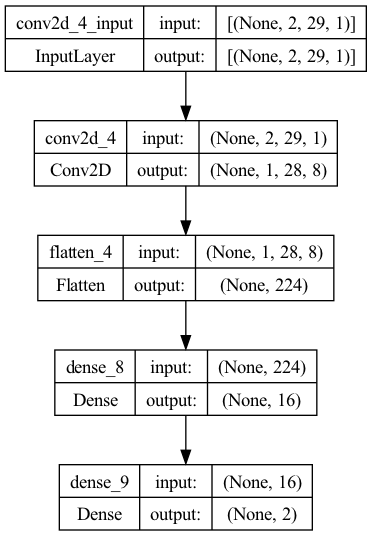

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(2, 29,1)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2,activation='softmax'))
# Here's the complete architecture of our model.

model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model training  
We used adam optimizer here as well as cross entropy loss function. We use cross entropy loss function since we are workin on a classification task here. The optimization algorithm we used here is ADAM, which combines moment of current and last optimization iteration. Here moment is difference between current weight in current iteration and last weight in last iteration. (Knowledge about ADAM optimization from class ppt L4-Optimization-09-12-2023.pdf, page 46-50)  
We checked that the best number of epoch is 250, so we use number of epoch 250 here.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(np.array(lis_training_new), np.array(lis_target), epochs=250)

Epoch 1/250


/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15/15 [==============================] - 0s 1ms/step - loss: 92.7144 - accuracy: 0.4822
Epoch 2/250
15/15 [==============================] - 0s 1ms/step - loss: 27.7537 - accuracy: 0.4889
Epoch 3/250
15/15 [==============================] - 0s 990us/step - loss: 18.2744 - accuracy: 0.4733
Epoch 4/250
15/15 [==============================] - 0s 960us/step - loss: 13.2648 - accuracy: 0.4356
Epoch 5/250
15/15 [==============================] - 0s 895us/step - loss: 9.6709 - accuracy: 0.4378
Epoch 6/250
15/15 [==============================] - 0s 987us/step - loss: 7.1810 - accuracy: 0.4933
Epoch 7/250
15/15 [==============================] - 0s 1ms/step - loss: 6.1497 - accuracy: 0.5356
Epoch 8/250
15/15 [==============================] - 0s 1ms/step - loss: 4.9892 - accuracy: 0.5667
Epoch 9/250
15/15 [==============================] - 0s 1ms/step - loss: 4.2620 - accuracy: 0.5889
Epoch 10/250
15/15 [==============================] - 0s 988us/step - loss: 5.4508 - accuracy: 0.6156
Epoch 1

### Testing our model predicting the NBA playoff game results in 2021-2022, 2022-2023 season

In [ ]:
score = model.evaluate(np.array(lis_test_new), np.array(lis_target1), verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.036434877663850784
Test accuracy: 0.9833333492279053


As given in accuracy of this model, our CNN model performs pretty well here!

### Testing our model predicting the NBA champion given the regular season result.

Here we want to have specific check on how well our CNN model predicts the NBA campion. We'll check the NBA East, West and overall Champion predicted by our CNN model compared to the real result.

Help from https://www.scaler.com/topics/find-index-of-element-in-list-python/ for how to find index of element in a list.

The following blocks of code gives us the list of full names and abbreviations for NBA teams in the East Conference and NBA teams in the West Conference.

In [ ]:
from nba_api.stats.endpoints import leaguestandings
standings = leaguestandings.LeagueStandings()

In [ ]:
data_games = standings.nba_response.get_data_sets()

In [ ]:
dict_conference_raw = {}
headers_teams = data_games['Standings']['headers']
data_teams = data_games['Standings']['data']
lis_east = []
lis_west = []

# Create a list of team ids for each conference
for item in data_teams:
  ind_conf = headers_teams.index('Conference') #conference column index in header
  conf = item[ind_conf]
  ind_id = headers_teams.index('TeamID')#team id column index in header
  team_id = item[ind_id]

  if conf == 'East':
    lis_east.append(team_id)
  else:
    lis_west.append(team_id)

In [ ]:
lis_east_names = []
lis_east_abbrev = []
lis_west_names = []
lis_west_abbrev = []

# Get team names and abbreviations for each conference
for item in lis_east:

  for item2 in nba_teams:
    if item2['id']==item:
      lis_east_names.append(item2['full_name'])
      lis_east_abbrev.append(item2['abbreviation'])

for item in lis_west:
  for item2 in nba_teams:
    if item2['id']==item:
      lis_west_names.append(item2['full_name'])
      lis_west_abbrev.append(item2['abbreviation'])


In [ ]:
lis_east_names,lis_east_abbrev

(['Boston Celtics',
  'Orlando Magic',
  'Milwaukee Bucks',
  'Philadelphia 76ers',
  'Miami Heat',
  'New York Knicks',
  'Indiana Pacers',
  'Cleveland Cavaliers',
  'Atlanta Hawks',
  'Brooklyn Nets',
  'Toronto Raptors',
  'Charlotte Hornets',
  'Chicago Bulls',
  'Washington Wizards',
  'Detroit Pistons'],
 ['BOS',
  'ORL',
  'MIL',
  'PHI',
  'MIA',
  'NYK',
  'IND',
  'CLE',
  'ATL',
  'BKN',
  'TOR',
  'CHA',
  'CHI',
  'WAS',
  'DET'])

Help from https://www.geeksforgeeks.org/check-if-element-exists-in-list-in-python/ over using in statement to find if an element is in a list or not.

Next we get playoff standings for the 2021-2022 and 2022-2023 seasons.

In [ ]:
#numerical features of NBA overall seasonal data.
sel = seasonal_data['LAL'].select_dtypes(['int64', 'float64']).columns

Function win_lose takes the NBA overall seasonal data with form given in our unfiltered testing data list 'lis_test', the given CNN model 'model_here' and the given numerical features 'num_index' and returns the winner's data and winner abbreviation and team id

In [ ]:
def win_lose(data,model_here,num_index):
  data_new = data[num_index]
  #print("-----")
  #print(data_new.columns)
  data_new = data_new.drop(columns=['TEAM_ID'])
  data_new = np.array(data_new,dtype='float64')
  score_here = model_here.evaluate(np.array([data_new,data_new]), np.array([1,1]), verbose=0)
  if score_here[1] ==1:
    winner_data = data.iloc[0,:]
    winner_id = data.iloc[0,:]['TEAM_ID']
    return winner_data, winner_id
  else:
    winner_data = data.iloc[1,:]
    winner_id = data.iloc[1,:]['TEAM_ID']
    return winner_data, winner_id

In [ ]:
win_lose(lis_test[59],model_here=model,num_index=sel)

(TEAM_ID                   1610612747
 TEAM_CITY                Los Angeles
 TEAM_NAME                     Lakers
 YEAR                         2022-23
 GP                                82
 WINS                              43
 LOSSES                            39
 WIN_PCT                        0.524
 CONF_RANK                          7
 DIV_RANK                           5
 PO_WINS                            8
 PO_LOSSES                          8
 CONF_COUNT                      15.0
 DIV_COUNT                          5
 NBA_FINALS_APPEARANCE            N/A
 FGM                             3516
 FGA                             7298
 FG_PCT                         0.482
 FG3M                             885
 FG3A                            2558
 FG3_PCT                        0.346
 FTM                             1691
 FTA                             2182
 FT_PCT                         0.775
 OREB                             818
 DREB                            2930
 REB        

Predicting east, west and final champion for 2021-2022 and 2022-2023 season

Help from https://www.geeksforgeeks.org/python-count-occurrences-element-list/ for python counter.

The following is function champions computing east, west and final champion in 2021-2022, 2022-2023 season. It takes the NBA overall seasonal data with form given in our unfiltered testing data list 'lis_test', the given CNN model 'model_here' and the given numerical features 'num_index' as well as the given year of season 'yr' for the champion prediction, list of east conference team names 'east_names' and list of west conference team names 'west_names.

In [ ]:
from collections import Counter

def champions(lis_post,yr,east_names,west_names,model_here,num_index):
  lis_name = [] #list of teams made into post season in given year

  for i in range(0,len(lis_post)):
    if lis_post[i]['YEAR'][0][:4]==yr:
      lis_name.append(lis_post[i]['TEAM_NAME'][0])

  counter_h = Counter(lis_name)
  #get first round games of post season in given year
  east_playoff_standing = []
  west_playoff_standing = []

  for i in range(0,len(lis_post)):
    year = lis_post[i]['YEAR'][0][:4]
    name = lis_post[i]['TEAM_NAME'][0]

    if year==yr and counter_h[name]==1:
      name_new = lis_post[i]['TEAM_CITY'][0]+' '+name

      if name_new in east_names:
        east_playoff_standing.append(lis_post[i])

      else:
        west_playoff_standing.append(lis_post[i])

  east_playoff_standing_new = {}
  for items in east_playoff_standing:
    if items['CONF_RANK'][0]<=4:
      rank = items['CONF_RANK'][0]
      east_playoff_standing_new[rank] = items

    elif items['CONF_RANK'][1]<=4:
      rank = items['CONF_RANK'][1]
      east_playoff_standing_new[rank] = items

  west_playoff_standing_new = {}
  for items in west_playoff_standing:
    if items['CONF_RANK'][0]<=4:
      rank = items['CONF_RANK'][0]
      west_playoff_standing_new[rank] = items

    elif items['CONF_RANK'][1]<=4:
      rank = items['CONF_RANK'][1]
      west_playoff_standing_new[rank] = items

  #predicting eastern champion
  print("------")
  winner_data1, winner_id1 = win_lose(data=east_playoff_standing_new[1],model_here=model_here,num_index=num_index)
  winner_data2, winner_id2 = win_lose(data=east_playoff_standing_new[2],model_here=model_here,num_index=num_index)
  winner_data3, winner_id3 = win_lose(data=east_playoff_standing_new[3],model_here=model_here,num_index=num_index)
  winner_data4, winner_id4 = win_lose(data=east_playoff_standing_new[4],model_here=model_here,num_index=num_index)
  print(winner_id1,winner_id2,winner_id3,winner_id4)
  column_here = east_playoff_standing_new[1].columns
  #predicting eastern playoff season 2nd round
  data_oppo1 = np.vstack([winner_data1,winner_data4])
  data_oppo1 = pd.DataFrame(data=data_oppo1,columns = column_here)
  data_oppo2 = np.vstack([winner_data2,winner_data3])
  data_oppo2 = pd.DataFrame(data=data_oppo2,columns = column_here)

  winner_data01, winner_id01 = win_lose(data=data_oppo1,model_here=model_here,num_index=num_index)
  winner_data02, winner_id02 = win_lose(data=data_oppo2,model_here=model_here,num_index=num_index)
  print(winner_id01,winner_id02)
  #predicting eastern playoff season 3rd round
  data_oppo01 = np.vstack([winner_data01,winner_data02])
  data_oppo01 = pd.DataFrame(data=data_oppo01,columns = column_here)
  winner_data001 , winner_id001 = win_lose(data=data_oppo01,model_here=model_here,num_index=num_index)
  print("east champion id", winner_id001)
  lis_final=[winner_data001]
  print("------")

  #predicting western champion
  winner_data1, winner_id1 = win_lose(data=west_playoff_standing_new[1],model_here=model_here,num_index=num_index)
  winner_data2, winner_id2 = win_lose(data=west_playoff_standing_new[2],model_here=model_here,num_index=num_index)
  winner_data3, winner_id3 = win_lose(data=west_playoff_standing_new[3],model_here=model_here,num_index=num_index)
  winner_data4, winner_id4 = win_lose(data=west_playoff_standing_new[4],model_here=model_here,num_index=num_index)
  print(winner_id1,winner_id2,winner_id3,winner_id4)
  #predicting western playoff season 2nd round
  data_oppo1 = np.vstack([winner_data1,winner_data4])
  data_oppo1 = pd.DataFrame(data=data_oppo1,columns = column_here)
  data_oppo2 = np.vstack([winner_data2,winner_data3])
  data_oppo2 = pd.DataFrame(data=data_oppo2,columns = column_here)
  winner_data01, winner_id01 = win_lose(data=data_oppo1,model_here=model_here,num_index=num_index)
  winner_data02, winner_id02 = win_lose(data=data_oppo2,model_here=model_here,num_index=num_index)
  print(winner_id01,winner_id02)
  #predicting western playoff season 3rd round
  data_oppo01 = np.vstack([winner_data01,winner_data02])
  data_oppo01 = pd.DataFrame(data=data_oppo01,columns = column_here)
  winner_data001 , winner_id001 = win_lose(data=data_oppo01,model_here=model_here,num_index=num_index)
  print("west champion id", winner_id001)
  lis_final.append(winner_data001)
  data_oppo3 = np.vstack(lis_final)
  data_oppo3 = pd.DataFrame(data=data_oppo3,columns = column_here)
  winner_data003 , winner_id003 = win_lose(data=data_oppo3,model_here=model_here,num_index=num_index)
  print(("------"))
  print("champion id:",winner_id003)

  return winner_id003

Helper function that prints the name of the team with a given id

In [ ]:
def get_team_name(id_, nba_teams):
  for team in nba_teams:
    if team['id']==id_:
      return team['full_name']

Predicting East, West and overall champion for 2021-2022 and 2022-2023 season.

In [ ]:
champ_21 = champions(lis_post=lis_test,yr='2021',east_names=lis_east_names,west_names=lis_west_names,model_here=model,num_index=sel)

------
1610612748 1610612738 1610612749 1610612755
1610612748 1610612738
east champion id 1610612738
------
1610612756 1610612763 1610612744 1610612742
1610612742 1610612744
west champion id 1610612744
------
champion id: 1610612744


In [ ]:
print(get_team_name(champ_21,nba_teams))

Golden State Warriors


In [ ]:
champ_22 = champions(lis_post=lis_test,yr='2022',east_names=lis_east_names,west_names=lis_west_names,model_here=model,num_index=sel)

------
1610612748 1610612738 1610612755 1610612752
1610612748 1610612738
east champion id 1610612748
------
1610612743 1610612747 1610612744 1610612756
1610612743 1610612747
west champion id 1610612743
------
champion id: 1610612743


In [ ]:
print(get_team_name(champ_22,nba_teams))

Denver Nuggets


Print out east, west and overall champion names predicted by our CNN model.

In [ ]:
for items in nba_teams:
  if items['id']==1610612738:
    print('2021-2022 East Champion:',items['full_name'])
  if items['id']==1610612744:
    print('2021-2022 West Champion:',items['full_name'])
    print('2021-2022 Overall Champion:',items['full_name'])


2021-2022 East Champion: Boston Celtics
2021-2022 West Champion: Golden State Warriors
2021-2022 Overall Champion: Golden State Warriors


In [ ]:
for items in nba_teams:
  if items['id']==1610612748:
    print('2022-2023 East Champion:',items['full_name'])
  if items['id']==1610612743:
    print('2022-2023 West Champion:',items['full_name'])
    print('2022-2023 Overall Champion:',items['full_name'])


2022-2023 West Champion: Denver Nuggets
2022-2023 Overall Champion: Denver Nuggets
2022-2023 East Champion: Miami Heat


Our CNN model predicts East, West and final champion in 2021-2022 and 2022-2023 season all correctly.

## Logistic regression model training and testing
We decide to try logistic model, taking regular season data for NBA teams from 2004-2005 season to 2022-2023 season as input and predict the outcomes of NBA playoff series or tournaments in these seasons.

Logistic regression model:  
We choose this model, since we think maybe some simple, linear related model for our NBA regular seasonal data is enough for our goals. However, we are having a classification task here in predicting NBA playoff series outcomes. Thus we choose logistic regression model which transforms output of linear regression models to values between 0 and 1 and to values generally close to either 0 or 1.  
(Knowledge about Logistic regression model from class ppt L6-regression-09-26-2023.pdf, special knowledge about changing output to values close to 0 or 1 from page 41, figure in page 42 and page 44 of L6-regression-09-26-2023.pdf)


The training and testing data set for logistic regression model is different from our CNN model taking all numerical features except TEAM_ID. There's further feature selections and some kind of further modification for training and testing datasets here. Thus we put the section of preparing training and testing dataset for logistic regression model inside this 'Logistic regression model training and testing' part.

### Preparing traing and testing data for logistic regression model

#### First stage data preparation

For training and testing data used for our logistic model, some further modification is needed. We substract 2nd row of each feature collections from the corresponding 1st row of each feature collections to create new X training data list 'lis_training_log' and new X testing data list 'lis_testing_log'. Then we create new X training dataset 'training_data' and X_testing dataset 'testing_data' by adding the feature names corresponding to each features stored in 'lis_training_log' and 'lis_testing_log'.

In [ ]:
lis_training_log = []
for i in range(0,len(lis_training_new)):
  lis_training_log.append(lis_training_new[i][0]-lis_training_new[i][1])

In [ ]:
lis_training_log = np.array(lis_training_log)

In [ ]:
lis_testing_log = []
for i in range(0,len(lis_test_new)):
  lis_testing_log.append(lis_test_new[i][0]-lis_test_new[i][1])

In [ ]:
lis_testing_log = np.array(lis_testing_log)

In [ ]:
lis_training_log.shape, lis_testing_log.shape

((450, 29), (60, 29))

Here when creating new X training and X testing dataset for logistic model, we add the feature names corresponding to each features stored in 'lis_training_log' and 'lis_testing_log'. Notice that there's already no feature 'TEAM_ID' in lis_training_log and lis_testing_log, so we drop this feature from list of numerical feature names sel.

In [ ]:
training_data=pd.DataFrame(data=lis_training_log,columns = sel[1:])

In [ ]:
testing_data = pd.DataFrame(data=lis_testing_log,columns = sel[1:])

#### Second stage data preparation

Also, we need to perform further **feature selection** to our training and testing data for logistic regression model. We complete this process by dropping columns with all zero values and by eliminating pairs of features with correlation of absolute value larger than or equal to 0.8.

For the colums having only zero values, we shall drop them.

In [ ]:
for column in training_data.columns:
  if sum(training_data[column]==0)==len(training_data):
    print(column)

CONF_COUNT
DIV_COUNT


Also notice that column GP in our training data is all zero or close to zero.

In [ ]:
sum(training_data['GP']),sum(testing_data['GP'])

(0.0, 0.0)

In [ ]:
training_data = training_data.drop(columns=['GP','CONF_COUNT','DIV_COUNT'])

In [ ]:
testing_data = testing_data.drop(columns=['GP','CONF_COUNT','DIV_COUNT'])

Now we trying to select features for our X training and X testing data. Here we check pairs of features with correlation larger than or equal to 0.8 or smaller than or equal to -0.8. After we found these pairs, we eliminate them.

In [ ]:
corr_matrix=training_data.corr()

In [ ]:
corr_matrix

,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,FGM,FGA,FG_PCT,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
WINS,1.000000,-0.999928,0.999031,-0.882926,-0.712521,0.676964,0.344459,0.350897,-0.093299,0.511072,...,-0.251147,0.373416,0.135105,0.311243,-0.226176,0.070333,-0.122657,0.346192,0.428153,-0.394958
LOSSES,-0.999928,1.000000,-0.999047,0.883282,0.712958,-0.677911,-0.345514,-0.349752,0.093884,-0.510095,...,0.249755,-0.375226,-0.137571,-0.311138,0.225696,-0.069142,0.120950,-0.348672,-0.426834,0.393421
WIN_PCT,0.999031,-0.999047,1.000000,-0.886203,-0.715051,0.678565,0.342801,0.349963,-0.094264,0.511980,...,-0.247821,0.372960,0.137036,0.308037,-0.227384,0.066753,-0.117033,0.347952,0.428049,-0.396033
CONF_RANK,-0.882926,0.883282,-0.886203,1.000000,0.842100,-0.721328,-0.413239,-0.307656,0.072500,-0.441686,...,0.161232,-0.359417,-0.185900,-0.244453,0.221752,0.036738,0.085107,-0.327421,-0.403370,0.394914
DIV_RANK,-0.712521,0.712958,-0.715051,0.842100,1.000000,-0.618366,-0.451253,-0.278420,0.061561,-0.400335,...,0.174677,-0.260611,-0.094709,-0.212880,0.134780,0.057463,0.034528,-0.258001,-0.392647,0.375033
PO_WINS,0.676964,-0.677911,0.678565,-0.721328,-0.618366,1.000000,0.515650,0.287256,-0.123914,0.461918,...,-0.235175,0.297732,0.083483,0.247149,-0.144457,0.011210,0.042417,0.264697,0.323146,-0.335822
PO_LOSSES,0.344459,-0.345514,0.342801,-0.413239,-0.451253,0.515650,1.000000,-0.082958,-0.170469,0.042796,...,-0.042640,0.071378,0.029549,-0.033983,0.012393,-0.090966,-0.020376,0.112689,0.012965,0.000700
FGM,0.350897,-0.349752,0.349963,-0.307656,-0.278420,0.287256,-0.082958,1.000000,0.596065,0.715782,...,-0.119960,0.280871,0.149463,0.696487,-0.126405,0.258940,0.091065,0.275187,0.822377,-0.705729
FGA,-0.093299,0.093884,-0.094264,0.072500,0.061561,-0.123914,-0.170469,0.596065,1.000000,-0.131980,...,0.415445,0.178186,0.435912,0.304601,-0.112582,0.128498,-0.133716,0.068557,0.454200,-0.326000
FG_PCT,0.511072,-0.510095,0.511980,-0.441686,-0.400335,0.461918,0.042796,0.715782,-0.131980,1.000000,...,-0.506843,0.181113,-0.201650,0.584241,-0.053356,0.213081,0.228420,0.273692,0.621802,-0.594186


<Figure size 1000x1000 with 0 Axes>

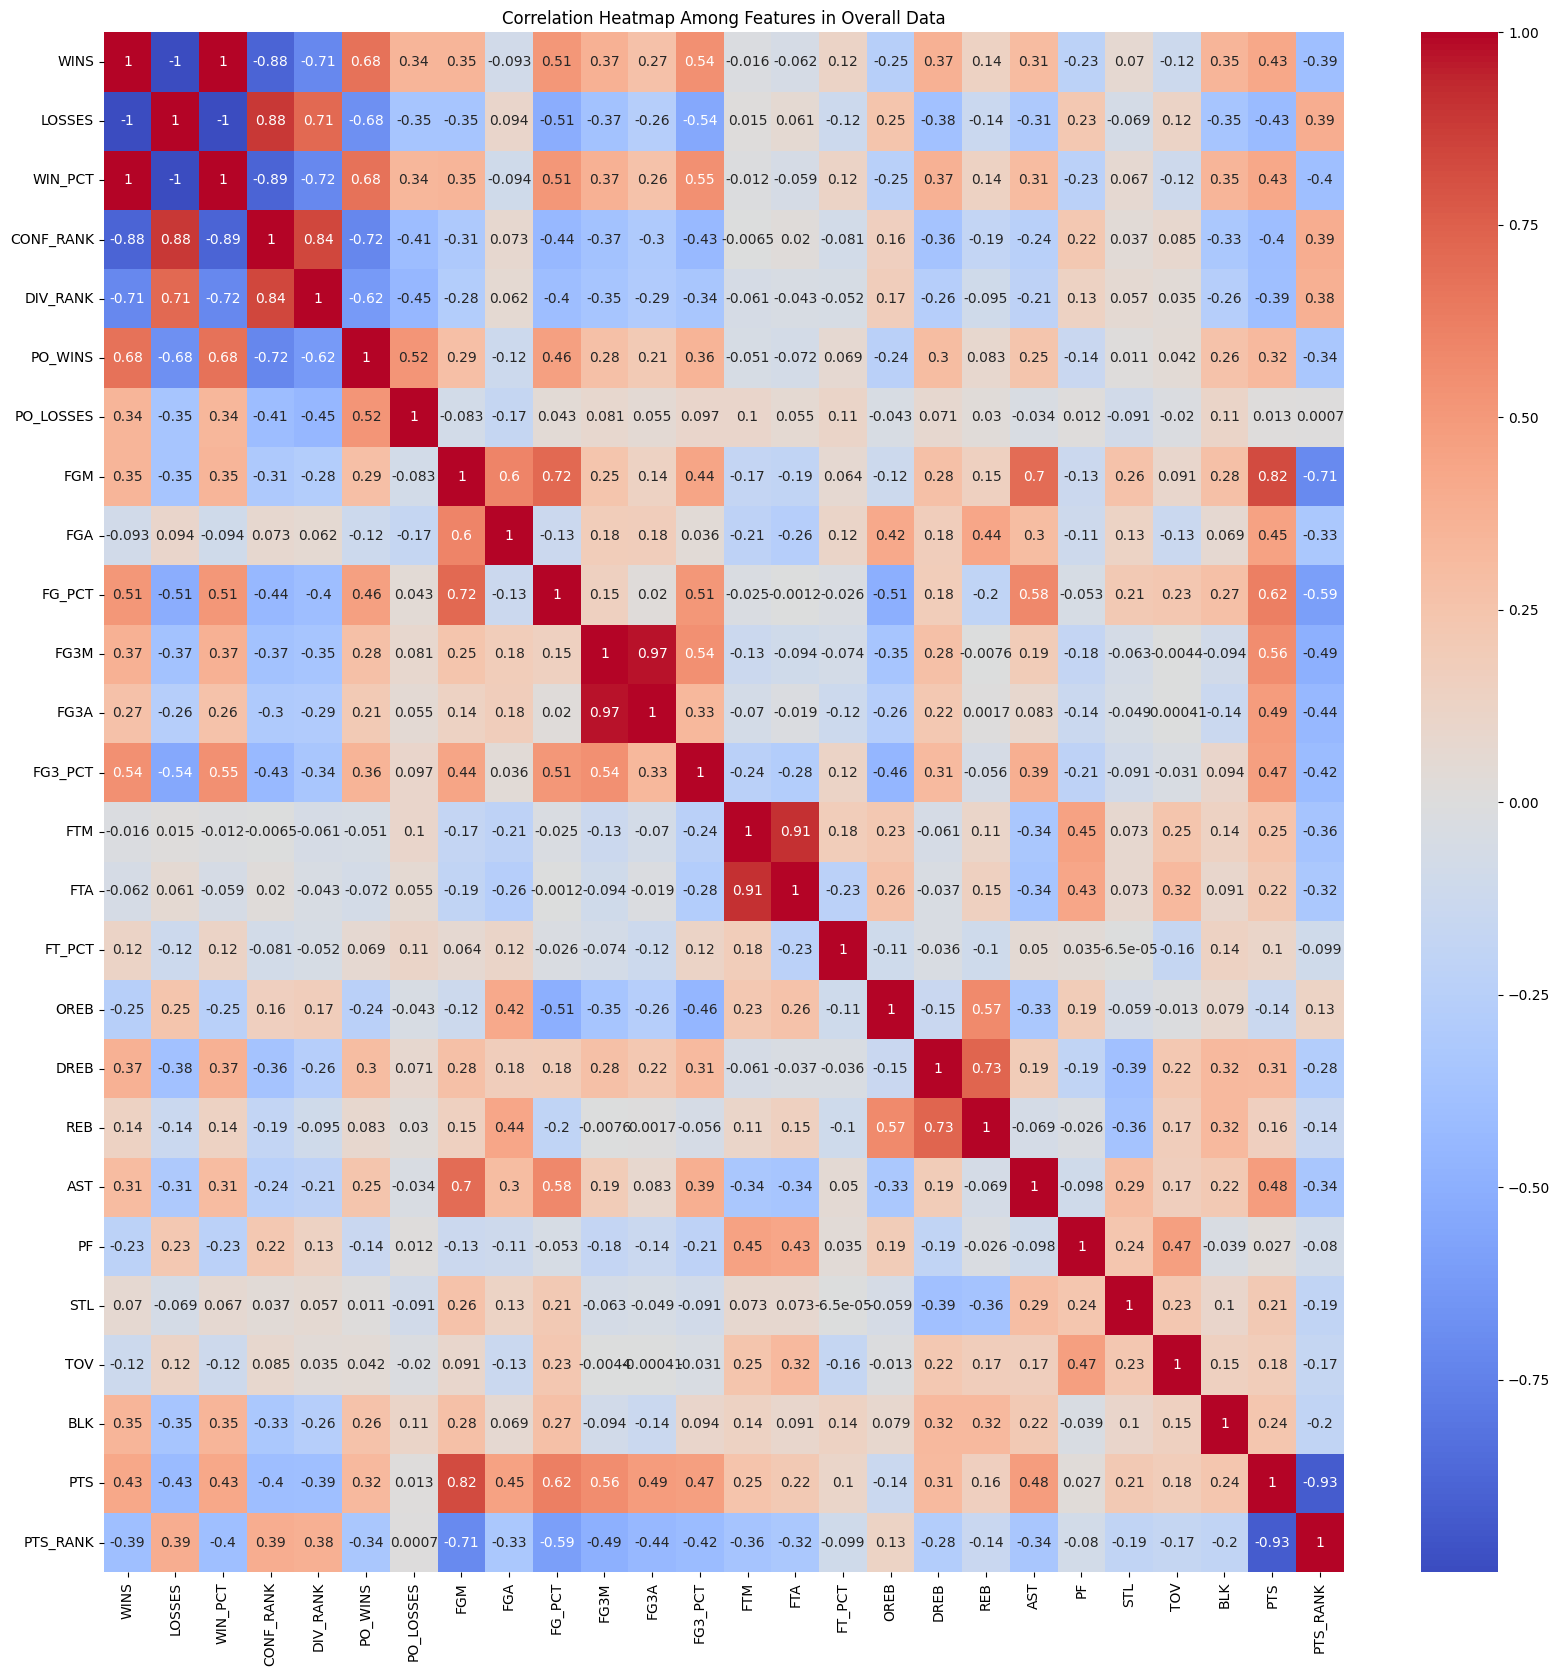

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.title("Correlation Heatmap Among Features in Overall Data")
#plt.tight_layout()
plt.show()

In [ ]:
# show row and columns index of correlation matrix
corr_matrix.index,corr_matrix.columns

(Index(['WINS', 'LOSSES', 'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS',
        'PO_LOSSES', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
        'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV',
        'BLK', 'PTS', 'PTS_RANK'],
       dtype='object'),
 Index(['WINS', 'LOSSES', 'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS',
        'PO_LOSSES', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
        'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV',
        'BLK', 'PTS', 'PTS_RANK'],
       dtype='object'))

In [ ]:
#print pairs of features with correlation >=0.8 or <= -0.8
for items in corr_matrix.columns:
  for items2 in corr_matrix.index:
    if abs(corr_matrix[items][items2])>=0.8 and items!=items2:
      print(items,items2)

WINS LOSSES
WINS WIN_PCT
WINS CONF_RANK
LOSSES WINS
LOSSES WIN_PCT
LOSSES CONF_RANK
WIN_PCT WINS
WIN_PCT LOSSES
WIN_PCT CONF_RANK
CONF_RANK WINS
CONF_RANK LOSSES
CONF_RANK WIN_PCT
CONF_RANK DIV_RANK
DIV_RANK CONF_RANK
FGM PTS
FG3M FG3A
FG3A FG3M
FTM FTA
FTA FTM
PTS FGM
PTS PTS_RANK
PTS_RANK PTS


In [ ]:
#show column names of training data, they are same with column names of correlation matrix
training_data.columns

Index(['WINS', 'LOSSES', 'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS',
       'PO_LOSSES', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'PF', 'STL', 'TOV',
       'BLK', 'PTS', 'PTS_RANK'],
      dtype='object')

Notice that WINS,LOSSES and WIN_PCT are essentially describing the same thing, thus we just need feature WIN_PCT here. Notice that in NBA regular season games, CONF_RANK, the conference rank is also decided by the winning percentage, thus we can just delete CONF_RANK. Now the pairs left are (FGM PTS), (FG3M FG3A),(FTM FTA), and (PTS PTS_RANK). Now we can just delete FGM, FG3A, FTM and PTS_RANK so for all 4 pairs, only 1 feature is kept. We keep feature PTS sicne we think number of points in whole season is a useful data.  
Now all pairs of features with absolute value of correlation larger than or equal to 0.8 are eliminated.

'training_data_new' and 'testing_data_new' are our newest X training and testing data with features selected and high correlation feature pairs eliminated.

In [ ]:
training_data_new = training_data.drop(columns=['WINS','LOSSES','CONF_RANK','FGM','FG3A','FTM','PTS_RANK'])

In [ ]:
testing_data_new = testing_data.drop(columns=['WINS','LOSSES','CONF_RANK','FGM','FG3A','FTM','PTS_RANK'])

In [ ]:
#check if testing and training new data have same columns after our feature selection
testing_data_new.columns==training_data_new.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
print("newly selected features:")
print(training_data_new.columns)

newly selected features:
Index(['WIN_PCT', 'DIV_RANK', 'PO_WINS', 'PO_LOSSES', 'FGA', 'FG_PCT', 'FG3M',
       'FG3_PCT', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'PF', 'STL',
       'TOV', 'BLK', 'PTS'],
      dtype='object')


Now, let's scale the data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(training_data_new)
training_data_new = scaler.transform(training_data_new)
testing_data_new = scaler.transform(testing_data_new)

### Training and testing our Logistic Regression model
Here for the model's solver, we use default 'lbfgs' solver, as given in detail in https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.  
  
Help over solvers of logistic regression model from
https://scikit-learn.org/stable/modules/linear_model.html#solvers  
  
Also, notice that as provided in our website above solvers for logistic regression model above, **optimization algorithm** used in the 'lbfgs' solver is approximation of a kind of quasi-Newton method. As a result, algorithm used "can deal with a wide range of different training data" and thus we decide to use the default solver (cited from https://scikit-learn.org/stable/modules/linear_model.html#solvers).

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(training_data_new, lis_target)

LogisticRegression()

In [ ]:
clf.score(testing_data_new,lis_target1)

1.0

**Our logistic regression predicted all post season games in 2021-2022 and 2022-2023 correctly. So it predicts East, West and final Champion in 2021-2022 and 2022-2023 season correctly.**
Now we go back to our neural network model, see if dropping features increase its performance.

## CNN model training and testing, with our newly selected features

For our X train data given in 'lis_training_new' and X test data given in 'lis_test_new' for our original CNN model taking all numerical featurex except team id, we only keep our newly selected 19 features as given in logistic model training and testing codes. The resulting new X training data here is 'lis_training_new01', resulting new X testing data is 'lis_testing_new01'

In [ ]:
lis_training_new01 = []
for i in range(0,len(lis_training)):
  data_ori = lis_training[i][sel]
  data_new = data_ori.drop(columns=['TEAM_ID','GP','CONF_COUNT','DIV_COUNT','WINS','LOSSES','CONF_RANK','FGM','FG3A','FTM','PTS_RANK'])
  data_new = np.array(data_new,dtype='float64')
  lis_training_new01.append(data_new)

In [ ]:
lis_testing_new01 = []
for i in range(0,len(lis_test)):
  data_ori = lis_test[i][sel]
  data_new = data_ori.drop(columns=['TEAM_ID','GP','CONF_COUNT','DIV_COUNT','WINS','LOSSES','CONF_RANK','FGM','FG3A','FTM','PTS_RANK'])
  data_new = np.array(data_new,dtype='float64')
  lis_testing_new01.append(data_new)

Now we use same CNN model as above, only with input shape different. The methodology and algorithms used for CNN model here are same as above. Also we use 200 for epoch number since we found that 200 is a good epoch number for our model here.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 1, 18, 8)          40        
                                                                 
 flatten_10 (Flatten)        (None, 144)               0         
                                                                 
 dense_20 (Dense)            (None, 16)                2320      
                                                                 
 dense_21 (Dense)            (None, 2)                 34        
                                                                 
Total params: 2394 (9.35 KB)
Trainable params: 2394 (9.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


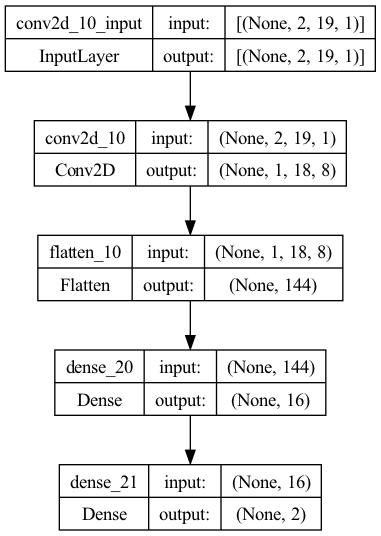

In [ ]:
model1 = models.Sequential()
model1.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(2, 19,1)))
model1.add(layers.Flatten())
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(2,activation='softmax'))
# Here's the complete architecture of our model.

model1.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True)

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history1 = model1.fit(np.array(lis_training_new01), np.array(lis_target), epochs=200)

Epoch 1/200


/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15/15 [==============================] - 0s 995us/step - loss: 443.4440 - accuracy: 0.4956
Epoch 2/200
15/15 [==============================] - 0s 1ms/step - loss: 103.6281 - accuracy: 0.4667
Epoch 3/200
15/15 [==============================] - 0s 982us/step - loss: 43.8654 - accuracy: 0.5022
Epoch 4/200
15/15 [==============================] - 0s 1ms/step - loss: 27.4343 - accuracy: 0.5067
Epoch 5/200
15/15 [==============================] - 0s 907us/step - loss: 26.1799 - accuracy: 0.5000
Epoch 6/200
15/15 [==============================] - 0s 904us/step - loss: 20.7306 - accuracy: 0.5467
Epoch 7/200
15/15 [==============================] - 0s 879us/step - loss: 18.5192 - accuracy: 0.5600
Epoch 8/200
15/15 [==============================] - 0s 968us/step - loss: 17.6904 - accuracy: 0.5333
Epoch 9/200
15/15 [==============================] - 0s 998us/step - loss: 19.5779 - accuracy: 0.5378
Epoch 10/200
15/15 [==============================] - 0s 931us/step - loss: 35.2675 - accuracy: 

In [ ]:
score1 = model1.evaluate(np.array(lis_testing_new01), np.array(lis_target1), verbose=0)
print("Test loss:", score1[0])
print("Test accuracy:", score1[1])

Test loss: 0.38176077604293823
Test accuracy: 0.949999988079071


There's no significant improvement here. In contrary, there's a little bit reduction in accuracy.

Now we define function win_lose again to adjust to our selection of new features as done in the logistic regression part.

In [ ]:
def win_lose(data,model_here,num_index):
  data_new = data[num_index]
  #print("-----")
  #print(data_new.columns)
  data_new = data_new.drop(columns=['TEAM_ID','GP','CONF_COUNT','DIV_COUNT','WINS','LOSSES','CONF_RANK','FGM','FG3A','FTM','PTS_RANK'])
  data_new = np.array(data_new,dtype='float64')
  score_here = model_here.evaluate(np.array([data_new,data_new]), np.array([1,1]), verbose=0)
  if score_here[1] ==1:
    winner_data = data.iloc[0,:]
    winner_id = data.iloc[0,:]['TEAM_ID']
    return winner_data, winner_id
  else:
    winner_data = data.iloc[1,:]
    winner_id = data.iloc[1,:]['TEAM_ID']
    return winner_data, winner_id

Rerun code for function champions here to make use of use our newly defined win_lose function.

In [ ]:
from collections import Counter
def champions(lis_post,yr,east_names,west_names,model_here,num_index):
  lis_name = [] #list of teams made into post season in given year
  for i in range(0,len(lis_post)):
    if lis_post[i]['YEAR'][0][:4]==yr:
      lis_name.append(lis_post[i]['TEAM_NAME'][0])
  counter_h = Counter(lis_name)
  #get first round games of post season in given year
  east_playoff_standing = []
  west_playoff_standing = []
  for i in range(0,len(lis_post)):
    year = lis_post[i]['YEAR'][0][:4]
    name = lis_post[i]['TEAM_NAME'][0]
    if year==yr and counter_h[name]==1:
      name_new = lis_post[i]['TEAM_CITY'][0]+' '+name
      if name_new in east_names:
        east_playoff_standing.append(lis_post[i])
      else:
        west_playoff_standing.append(lis_post[i])
  east_playoff_standing_new = {}
  for items in east_playoff_standing:
    if items['CONF_RANK'][0]<=4:
      rank = items['CONF_RANK'][0]
      east_playoff_standing_new[rank] = items
    elif items['CONF_RANK'][1]<=4:
      rank = items['CONF_RANK'][1]
      east_playoff_standing_new[rank] = items
  west_playoff_standing_new = {}
  for items in west_playoff_standing:
    if items['CONF_RANK'][0]<=4:
      rank = items['CONF_RANK'][0]
      west_playoff_standing_new[rank] = items
    elif items['CONF_RANK'][1]<=4:
      rank = items['CONF_RANK'][1]
      west_playoff_standing_new[rank] = items
  #predicting eastern champion
  print("------")
  winner_data1, winner_id1 = win_lose(data=east_playoff_standing_new[1],model_here=model_here,num_index=num_index)
  winner_data2, winner_id2 = win_lose(data=east_playoff_standing_new[2],model_here=model_here,num_index=num_index)
  winner_data3, winner_id3 = win_lose(data=east_playoff_standing_new[3],model_here=model_here,num_index=num_index)
  winner_data4, winner_id4 = win_lose(data=east_playoff_standing_new[4],model_here=model_here,num_index=num_index)
  print(winner_id1,winner_id2,winner_id3,winner_id4)
  column_here = east_playoff_standing_new[1].columns
  #predicting east playoff season 2nd round
  data_oppo1 = np.vstack([winner_data1,winner_data4])
  data_oppo1 = pd.DataFrame(data=data_oppo1,columns = column_here)
  data_oppo2 = np.vstack([winner_data2,winner_data3])
  data_oppo2 = pd.DataFrame(data=data_oppo2,columns = column_here)

  winner_data01, winner_id01 = win_lose(data=data_oppo1,model_here=model_here,num_index=num_index)
  winner_data02, winner_id02 = win_lose(data=data_oppo2,model_here=model_here,num_index=num_index)
  print(winner_id01,winner_id02)
  #predicting east playoff season 3rd round
  data_oppo01 = np.vstack([winner_data01,winner_data02])
  data_oppo01 = pd.DataFrame(data=data_oppo01,columns = column_here)
  winner_data001 , winner_id001 = win_lose(data=data_oppo01,model_here=model_here,num_index=num_index)
  print("east champion id", winner_id001)
  lis_final=[winner_data001]
  print("------")
  #predicting eastern champion
  winner_data1, winner_id1 = win_lose(data=west_playoff_standing_new[1],model_here=model_here,num_index=num_index)
  winner_data2, winner_id2 = win_lose(data=west_playoff_standing_new[2],model_here=model_here,num_index=num_index)
  winner_data3, winner_id3 = win_lose(data=west_playoff_standing_new[3],model_here=model_here,num_index=num_index)
  winner_data4, winner_id4 = win_lose(data=west_playoff_standing_new[4],model_here=model_here,num_index=num_index)
  print(winner_id1,winner_id2,winner_id3,winner_id4)
  #predicting east playoff season 2nd round
  data_oppo1 = np.vstack([winner_data1,winner_data4])
  data_oppo1 = pd.DataFrame(data=data_oppo1,columns = column_here)
  data_oppo2 = np.vstack([winner_data2,winner_data3])
  data_oppo2 = pd.DataFrame(data=data_oppo2,columns = column_here)
  winner_data01, winner_id01 = win_lose(data=data_oppo1,model_here=model_here,num_index=num_index)
  winner_data02, winner_id02 = win_lose(data=data_oppo2,model_here=model_here,num_index=num_index)
  print(winner_id01,winner_id02)
  #predicting east playoff season 3rd round
  data_oppo01 = np.vstack([winner_data01,winner_data02])
  data_oppo01 = pd.DataFrame(data=data_oppo01,columns = column_here)
  winner_data001 , winner_id001 = win_lose(data=data_oppo01,model_here=model_here,num_index=num_index)
  print("west champion id", winner_id001)
  lis_final.append(winner_data001)
  data_oppo3 = np.vstack(lis_final)
  data_oppo3 = pd.DataFrame(data=data_oppo3,columns = column_here)
  winner_data003 , winner_id003 = win_lose(data=data_oppo3,model_here=model_here,num_index=num_index)
  print("champion id:",winner_id003)

  return winner_id003

Again we predict the particular East, West and overall champion for 2021-2022 and 2022-2023 season.

In [ ]:
champ_21 = champions(lis_post=lis_test,yr='2021',east_names=lis_east_names,west_names=lis_west_names,model_here=model1,num_index=sel)

------
1610612748 1610612738 1610612749 1610612755
1610612748 1610612738
east champion id 1610612738
------
1610612756 1610612763 1610612744 1610612742
1610612742 1610612744
west champion id 1610612744
champion id: 1610612744


In [ ]:
print(get_team_name(champ_21, nba_teams))

Golden State Warriors


In [ ]:
champions(lis_post=lis_test,yr='2022',east_names=lis_east_names,west_names=lis_west_names,model_here=model1,num_index=sel)

------
1610612748 1610612738 1610612755 1610612752
1610612748 1610612738
east champion id 1610612738
------
1610612743 1610612747 1610612744 1610612756
1610612743 1610612744
west champion id 1610612743
champion id: 1610612743


1610612743

In [ ]:
print(get_team_name(champ_22, nba_teams))

Denver Nuggets


Now we print out predicted names of teams winning 2021-2022 or 2022-2023 East, West or overall champion.

In [ ]:
for items in nba_teams:
  if items['id']==1610612738:
    print('2021-2022 East Champion:',items['full_name'])
  if items['id']==1610612744:
    print('2021-2022 West Champion:',items['full_name'])
    print('2021-2022 Overall Champion:',items['full_name'])

2021-2022 East Champion: Boston Celtics
2021-2022 West Champion: Golden State Warriors
2021-2022 Overall Champion: Golden State Warriors


In [ ]:
for items in nba_teams:
  if items['id']==1610612738:
    print('2022-2023 East Champion:',items['full_name'])
  if items['id']==1610612743:
    print('2022-2023 West Champion:',items['full_name'])
    print('2022-2023 Overall Champion:',items['full_name'])

2022-2023 East Champion: Boston Celtics
2022-2023 West Champion: Denver Nuggets
2022-2023 Overall Champion: Denver Nuggets


The prediction of particular East, West and Overall champion could still be better. Only east champion for 2022-2023 season is predicted wrong, the other champions are predicted correctly.

The CNN model has no significant improvement in accuracy after our feature selection but some reduction in accuracy.   
For the original CNN model (no further feature selection, all numerical feature included except team id), its performance is as good as performance of our logistic regression model, given that both model have accuracy close to 1 in predicting each NBA playoff series results and both model predict NBA East, West and final champion in 2021-2022 and 2022-2023 season correctly. For the CNN model with our feature selection, the accuracy drops a little bit and is around 0.95, and the East champion in 2022-2023 season is predicted wrong (ALL OTHER CHAMPIONS PREDICTED CORRECTLY).   
  
Our feature selection undermined and decreased the performance of our CNN model. It seems like feature selection by correlation values might not be a nice option for CNN model.  
  


### Further exploration
We are not sure if high performance in accuracy in prediction of NBA post season playoff series by our original CNN model (taking all numerical features except team id) and our logistic regression model is due to the fact that our testing dataset is **too small** compared to our training dataset.   
Here we use first 300 data in our X training dataset and y training dataset (lis_training_new and lis_target correspondingly) for our original CNN model as training dataset to a model in **exact same format and setup as our original CNN model**. The rest of 150 data in training datasets of original CNN model will be used for the testing of this newest CNN model.   
We will also use first 300 data in X training dataset and y training dataset (training_data_new and lis_target correspondingly) for our logistic regression model above as training dataset to a model in **exact same format and setup as our logistic regression model above**. The rest of 150 data in training datasets of logistic regression model above will be used for the testing of this new logistic regression model.

#### New training and testing dataset for original CNN model

Model in **exact same format and setup and having exact same hyper parameters like number of epoches** as the original CNN model taking all numerical features except team id. Methdologies and optimization algorithm are the same.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1, 28, 8)          40        
                                                                 
 flatten_2 (Flatten)         (None, 224)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                3600      
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3674 (14.35 KB)
Trainable params: 3674 (14.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


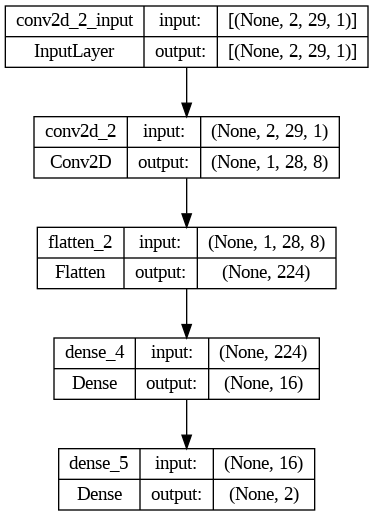

In [ ]:
model3 = models.Sequential()
model3.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(2, 29,1)))
model3.add(layers.Flatten())
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(2,activation='softmax'))
# Here's the complete architecture of our model.

model3.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

tf.keras.utils.plot_model(model3, show_shapes=True, show_layer_names=True)

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model3.fit(np.array(lis_training_new[:300]), np.array(lis_target[:300]), epochs=250)

Epoch 1/250
10/10 [==============================] - 1s 3ms/step - loss: 122.5253 - accuracy: 0.4833
Epoch 2/250
10/10 [==============================] - 0s 3ms/step - loss: 33.0768 - accuracy: 0.5000
Epoch 3/250
10/10 [==============================] - 0s 3ms/step - loss: 14.7772 - accuracy: 0.4300
Epoch 4/250
10/10 [==============================] - 0s 3ms/step - loss: 9.1389 - accuracy: 0.4833
Epoch 5/250
10/10 [==============================] - 0s 4ms/step - loss: 9.1805 - accuracy: 0.4833
Epoch 6/250
10/10 [==============================] - 0s 3ms/step - loss: 8.1304 - accuracy: 0.4133
Epoch 7/250
10/10 [==============================] - 0s 3ms/step - loss: 7.1647 - accuracy: 0.4467
Epoch 8/250
10/10 [==============================] - 0s 3ms/step - loss: 6.7719 - accuracy: 0.4900
Epoch 9/250
10/10 [==============================] - 0s 3ms/step - loss: 5.7882 - accuracy: 0.4700
Epoch 10/250
10/10 [==============================] - 0s 3ms/step - loss: 4.5602 - accuracy: 0.5400
Epoch

Testing our newest CNN model predicting some new testing set's NBA playoff series results.

In [ ]:
score3 = model3.evaluate(np.array(lis_training_new[300:]), np.array(lis_target[300:]), verbose=0)
print("Test loss:", score3[0])
print("Test accuracy:", score3[1])

Test loss: 0.18709486722946167
Test accuracy: 0.9266666769981384


In [ ]:
len(lis_training_new[:300]),len(lis_training_new[300:]),len(lis_target[:300]),len(lis_target[300:])

(300, 150, 300, 150)

There's surely some notable decrease in accuracy of predicting each NBA playoff series' results from 98% to 92% for our CNN model taking all numerical features (except team id) when *training set decrease in size and testing set increase in size*.

#### New training and testing dataset for logistic regression model

In [ ]:
training_data_new[:300].shape,training_data_new[300:].shape

((300, 19), (150, 19))

In [ ]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression()
clf1.fit(training_data_new[:300], lis_target[:300])

LogisticRegression()

In [ ]:
clf1.score(training_data_new[300:],lis_target[300:])

0.9866666666666667

When training dataset decrease in size and testing dataset increase in size, there's very minor fall in accuracy of predicting NBA playoff series results, from 100% to 98.67%.   
  
For original CNN model taking all numerical features except team id, when training dataset decrease in size and testing dataset increase in size, the model's performance has some notable decrease of about 6% in accuracy predicting NBA playoff series outcomes from 98% to 92%.  
For logistic regression model, under same changes of training and testing datasets, the decrease in accuracy is less than 1.5%. Also the logistic regression model's accuracy of 98.67% **under this condition** is **clearly better** than performance of our original CNN model under this condition.  **Our current analysis and comparison shows that while decresing size of training dataset and increasing size of testing dataset, the logistic regression model is less influenced and performs better compared to the original CNN model taking all numerical features except team id.**


## Conclusion

Since further selection of features only somehow decrease performance of CNN model, our conclusion including model evaluation and comparison below focuses on the original CNN model and logistic regression model.

Generally both original CNN model taking all numerical features except team id and our logistic regression model finished our goals above in introduction section well. However, original CNN model's performance is not stable enough and during some of our testings, it only gives accuracy around 94% or even 78%. In contrast, logistic regression model's performance is stable in all different runtimes. **Under the metric of stability of model performance, logistic regression model performs better than the original CNN model.** Finally, we checked performance of original CNN model and logistic regression model under **the condition that there's a decrease in size of training dataset and increase of size in testing dataset**. Although both original CNN model and logistic regression model has a nice performance of accuracy over 90%, compared to the original CNN model, the logistic regression model **not only is less influenced by the condition, but also performs better**.

## Difficulties and future work

The following small block of code corresponds to the difficulty and furure work parts of our final project presentation part. The player's data was so huge and we were not able to make use of it. In the furure we may try to use player's data for our further prediction of NBA champion. We may also try with some other classification models for prediction of NBA playoff series results.


### Getting Player Career Stats

In [ ]:
# Get player name from player id
def get_player_name(player_id, player_dict):
    player_info = [player for player in player_dict if player['id'] == player_id][0]
    return player_info['full_name']

# Get all player ids
from nba_api.stats.static import players

player_dict = players.get_players()
player_ids = [x['id'] for x in player_dict]
print(f'Number of players: {len(player_ids)}')

Number of players: 4815


In [ ]:
import time

# Filter player_ids to only include ids of players
# that played from 2004-05 onwards
from nba_api.stats.endpoints import playercareerstats

all_careers = []
batch_size = 50  # Define the size of each batch
delay = 5  # Define the delay between each batch in seconds

# Process the players in batches
for i in range(0, len(player_ids), batch_size):
    batch = player_ids[i:i+batch_size]
    for player in batch:
        player_career = playercareerstats.PlayerCareerStats(player_id=player)
        player_df = player_career.get_data_frames()[0]

        # Filter out seasons we don't want
        player_df = player_df[player_df['SEASON_ID'] >= '2004-05']

        # Check that they actually played a season or more
        if player_df.shape[0] != 0:
            all_careers.append(player_df)
            player_name = get_player_name(player, player_dict)
            print(f'Career for {player_name}, id: {player} added!')
    time.sleep(delay)  # Wait for a while before processing the next batch

Career for Shareef Abdur-Rahim, id: 949 added!
Career for Alex Abrines, id: 203518 added!
Career for Precious Achiuwa, id: 1630173 added!
Career for Alex Acker, id: 101165 added!
Career for Quincy Acy, id: 203112 added!


KeyboardInterrupt: 

In [ ]:
import pickle
example_obj = all_careers
fileObj = open('data.obj', 'wb')
pickle.dump(example_obj,fileObj)
fileObj.close()

In [ ]:
import pickle

fileObj = open('data.obj', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()

In [ ]:
exampleObj[1010]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1626145,2015-16,00,1610612750,MIN,20.0,37,0,573.0,56,...,0.718,7,40,47,108,31,3,33,33,156
1,1626145,2016-17,00,1610612750,MIN,21.0,60,0,774.0,75,...,0.767,10,57,67,156,48,5,38,50,209
2,1626145,2017-18,00,1610612750,MIN,22.0,82,11,1467.0,150,...,0.877,16,116,132,232,95,6,59,110,416
3,1626145,2018-19,00,1610612750,MIN,23.0,68,23,1560.0,185,...,0.841,23,111,134,327,81,5,47,78,468
4,1626145,2019-20,00,1610612763,MEM,24.0,65,6,1232.0,197,...,0.741,9,94,103,285,59,6,55,44,484
5,1626145,2020-21,00,1610612763,MEM,25.0,70,9,1223.0,178,...,0.911,21,119,140,259,64,6,48,31,442
6,1626145,2021-22,00,1610612763,MEM,26.0,73,23,1549.0,249,...,0.818,17,159,176,324,66,2,46,32,632
7,1626145,2022-23,00,1610612763,MEM,27.0,80,22,1939.0,311,...,0.800,28,172,200,417,83,6,74,32,823
8,1626145,2023-24,00,1610612764,WAS,27.0,13,13,347.0,58,...,0.667,4,30,34,61,11,2,10,13,135


## Citation Page

#### Modeling citations
Reminder that logistic regression is a possible choice for model:  
https://github.com/wtjw1993/nba_statistics
  
How to use softmax for multiclass classification:  
https://www.turing.com/kb/softmax-multiclass-neural-networks
  
Meaning of metrics ‘accuracy’ in keras,   
https://keras.io/api/metrics/accuracy_metrics/#accuracy-class
frequency y_pred meets y_true.  
Same explanation works for score metric of score function in logistic regression, as we've checked.
  
About score function of logistic regression object in sklearn:  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score

#### Further modeling citations for logistic regression model
Website and source about logistic regression solver:  
https://scikit-learn.org/stable/modules/linear_model.html#solvers
  
Citation about Broyden–Fletcher–Goldfarb–Shanno algorithm, the quasi-Newton method approximated in 'lbfgs':  
https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm

Website for solver and for example logistic regression code (giving inspiration to our training and testing of logistic regression model):  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

#### Programming and coding citations:
Selecting rows with column value equals to some specific value:  
https://www.statology.org/pandas-select-rows-based-on-column-values/
  
Answer from Rafael, solving pickle package related issue:  
https://stackoverflow.com/questions/68625748/attributeerror-cant-get-attribute-new-block-on-module-pandas-core-internal
  
CNN network training and evaluation:  
https://keras.io/examples/vision/mnist_convnet/  
Our CNN network training and evaluation code is inspired from here.
  
#### NBA background knowledge citation:
Knowledge about NBA league expansion:  
https://en.wikipedia.org/wiki/Expansion_of_the_National_Basketball_Association

background info to start of 2004 regular season:  
https://en.wikipedia.org/wiki/2004%E2%80%9305_NBA_season#Playoffs

NBA play in tournament:  
https://en.wikipedia.org/wiki/NBA_play-in_tournament
  
Also information from google that Brooklyn net was once New Jersey net.
New Oreleans Pelicans was once named hornet… etc.
  
NBA regular season ranking:  
https://www.kaggle.com/datasets/nathanlauga/nba-games

#### Specific citation of class provided PPT
Sen, Mrinal K. Class GEO 398D Introduction to Machine Learning in Geosciences, L4-Optimization-09-12-2023.pdf, accessed Nov 29th 2023.   
  
Sen, Mrinal K. Class GEO 398D Introduction to Machine Learning in Geosciences, L6-regression-09-26-2023.pdf, accessed Nov 29th 2023.  
     
Sen, Mrinal K. Class GEO 398D Introduction to Machine Learning in Geosciences, L12-CNN-11-14-2023.pdf, accessed Nov 29th 2023.

#### Generally we got all of our data and some help over our coding from nba_api package.
Website  
https://github.com/swar/nba_api  
  
#### The code in beginning of this notebook in package installiation and data extraction part are inspired from example code in   
https://github.com/swar/nba_api/blob/master/docs/examples/Basics.ipynb  
and  
https://github.com/swar/nba_api/blob/master/docs/examples/Finding%20Games.ipynb  
and  
https://github.com/swar/nba_api/blob/master/docs/examples/PlayByPlay.ipynb

For the part of code finding the name and abbreviations of teams in NBA East conference and those in NBA west conference, we got help from code in nba api as follow:  
https://github.com/swar/nba_api/blob/master/src/nba_api/stats/endpoints/leaguestandings.py


*Specific help in the case that some dialogue with my parents incentivized us to add some more analysis about model comparision and selection.*





Specific help that code in **Package Installation part and *first block of code* in Data Extraction part** of this ipynb document is borrowed from     
https://github.com/swar/nba_api/blob/master/docs/examples/Finding%20Games.ipynb

### Final thanks to Prof. Sen and TA Shuhua!